In [1]:
import json
import gzip
import tarfile
import numpy as np
import datetime, time
import pytz
import pickle
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
import math

C:\Users\ashis\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
load_data = True

if not load_data:
    
    tar = tarfile.open("data/tweet_data.tar.gz", "r:gz")
    
    avgFollowers = {}
    tweetTimes = {}
    avgRetweets = {}

    pst_tz = pytz.timezone('US/Pacific')
    
    for member in tar.getmembers():
        f = tar.extractfile(member)
        followerData = []
        timeData = []
        retweetData = []
        for line in f.readlines():
            entry = json.loads(line)
            #Follower Data
            followerData.append(entry['author']['followers'])
            #Tweet time Data
            citation = entry['citation_date']
            timeData.append(datetime.datetime.fromtimestamp(citation, pst_tz))
            #Retweet Data
            retweetData.append(entry['metrics']['citations']['total'])
        
        avgFollowers[member.name] = (sum(followerData) / len (followerData))
        avgRetweets[member.name] =  (sum(retweetData) / len(retweetData))
        tweetTimes[member.name] = timeData
        
        f.close()
    
    tar.close()
    
    with open('data/train/part1/part_1_1_data.pkl' , 'wb') as file:
        pickle.dump([avgFollowers, tweetTimes, avgRetweets] , file)
    
else:
    with open('data/train/part1/part_1_1_data.pkl' , 'rb') as file:
        [avgFollowers, tweetTimes, avgRetweets] = pickle.load(file)
    

In [4]:
def getHourlyTweets(tweetTimes):
    hourlyTweetCount = {}
    
    for i in range(14,32):
        for j in range(0,24):
            hourlyTweetCount[str(i) + ' '+ str(j)] = 0
    
    for i in range(1,8):
        for j in range(0,24):
            hourlyTweetCount[str(i) + ' '+ str(j)] = 0
    
    for tweet in tweetTimes:
        day = tweet.day
        hour = tweet.hour
        currentCount = hourlyTweetCount[str(day) + ' ' + str(hour)]
        hourlyTweetCount[str(day) + ' ' + str(hour)] = currentCount + 1
        
    return hourlyTweetCount

In [5]:
for key in avgFollowers.keys():
    print('The avg followers of the users tweeting with %s are %f'% (key[7:-4], avgFollowers[key]))

The avg followers of the users tweeting with #superbowl are 8858.974663
The avg followers of the users tweeting with #sb49 are 10267.316849
The avg followers of the users tweeting with #patriots are 3309.978828
The avg followers of the users tweeting with #gopatriots are 1401.895509
The avg followers of the users tweeting with #gohawks are 2203.931767
The avg followers of the users tweeting with #nfl are 4653.252286


In [6]:
for key in avgRetweets.keys():
    print('The avg retweets of the users tweeting with %s are %f'% (key[7:-4], avgRetweets[key]))

The avg retweets of the users tweeting with #superbowl are 2.388272
The avg retweets of the users tweeting with #sb49 are 2.511149
The avg retweets of the users tweeting with #patriots are 1.782816
The avg retweets of the users tweeting with #gopatriots are 1.400084
The avg retweets of the users tweeting with #gohawks are 2.014617
The avg retweets of the users tweeting with #nfl are 1.538533


In [7]:
for key in tweetTimes.keys():
    hourlyTweetCounts = getHourlyTweets(tweetTimes[key])
    avgTweetsHourly = sum(hourlyTweetCounts.values()) / len(hourlyTweetCounts.values())
    print('The avg tweets per hour with the hashtag %s are %f'% (key[7:-4], avgTweetsHourly))


The avg tweets per hour with the hashtag #superbowl are 2247.945000
The avg tweets per hour with the hashtag #sb49 are 1378.251667
The avg tweets per hour with the hashtag #patriots are 816.188333
The avg tweets per hour with the hashtag #gopatriots are 43.720000
The avg tweets per hour with the hashtag #gohawks are 313.560000
The avg tweets per hour with the hashtag #nfl are 431.706667


In [8]:
def plotHourlyTweets(tweetTimes):
    x = []
    y = []
    for i in range(14,32):
        for j in range(0,24):
            key = str(i)+ ' '+ str(j)
            #x.append(str(j) + ':00 - ' + str(j+1)+ ':00')
            y.append(tweetTimes[key])
        #plt.figure(figsize=(35,15))
        #binwidth = 0.7
        #plt.bar(xx , y, width = binwidth)
        #plt.xticks(xx, x)
        #plt.xlabel('Day and Time')
        #plt.ylabel('Tweet count')
        #plt.title('Hourly Tweets for %s' % ('01/' + str(i)))
        #plt.show()
        
    for i in range(1,8):
        for j in range(0,24):
            key = str(i)+ ' '+ str(j)
            #xx = np.arange(0,24)
            #x.append(str(j) + ':00 - ' + str(j+1)+ ':00')
            y.append(tweetTimes[key])
    
    plt.figure(figsize=(30,30))
    binwidth = 0.7
    x = np.arange(600)
    plt.bar(x , y, width = binwidth)
    #plt.xticks(xx, x)
    plt.xlabel('Hourly tweet count for all days', fontsize = 22)
    plt.ylabel('Tweet count', fontsize = 18)
    plt.suptitle('Hourly Tweets for all days between 01/14 - 02/07', fontsize = 30)
    plt.show()

## Q1.1 Plotting the number of tweets per hour across all days of data with the #superbowl

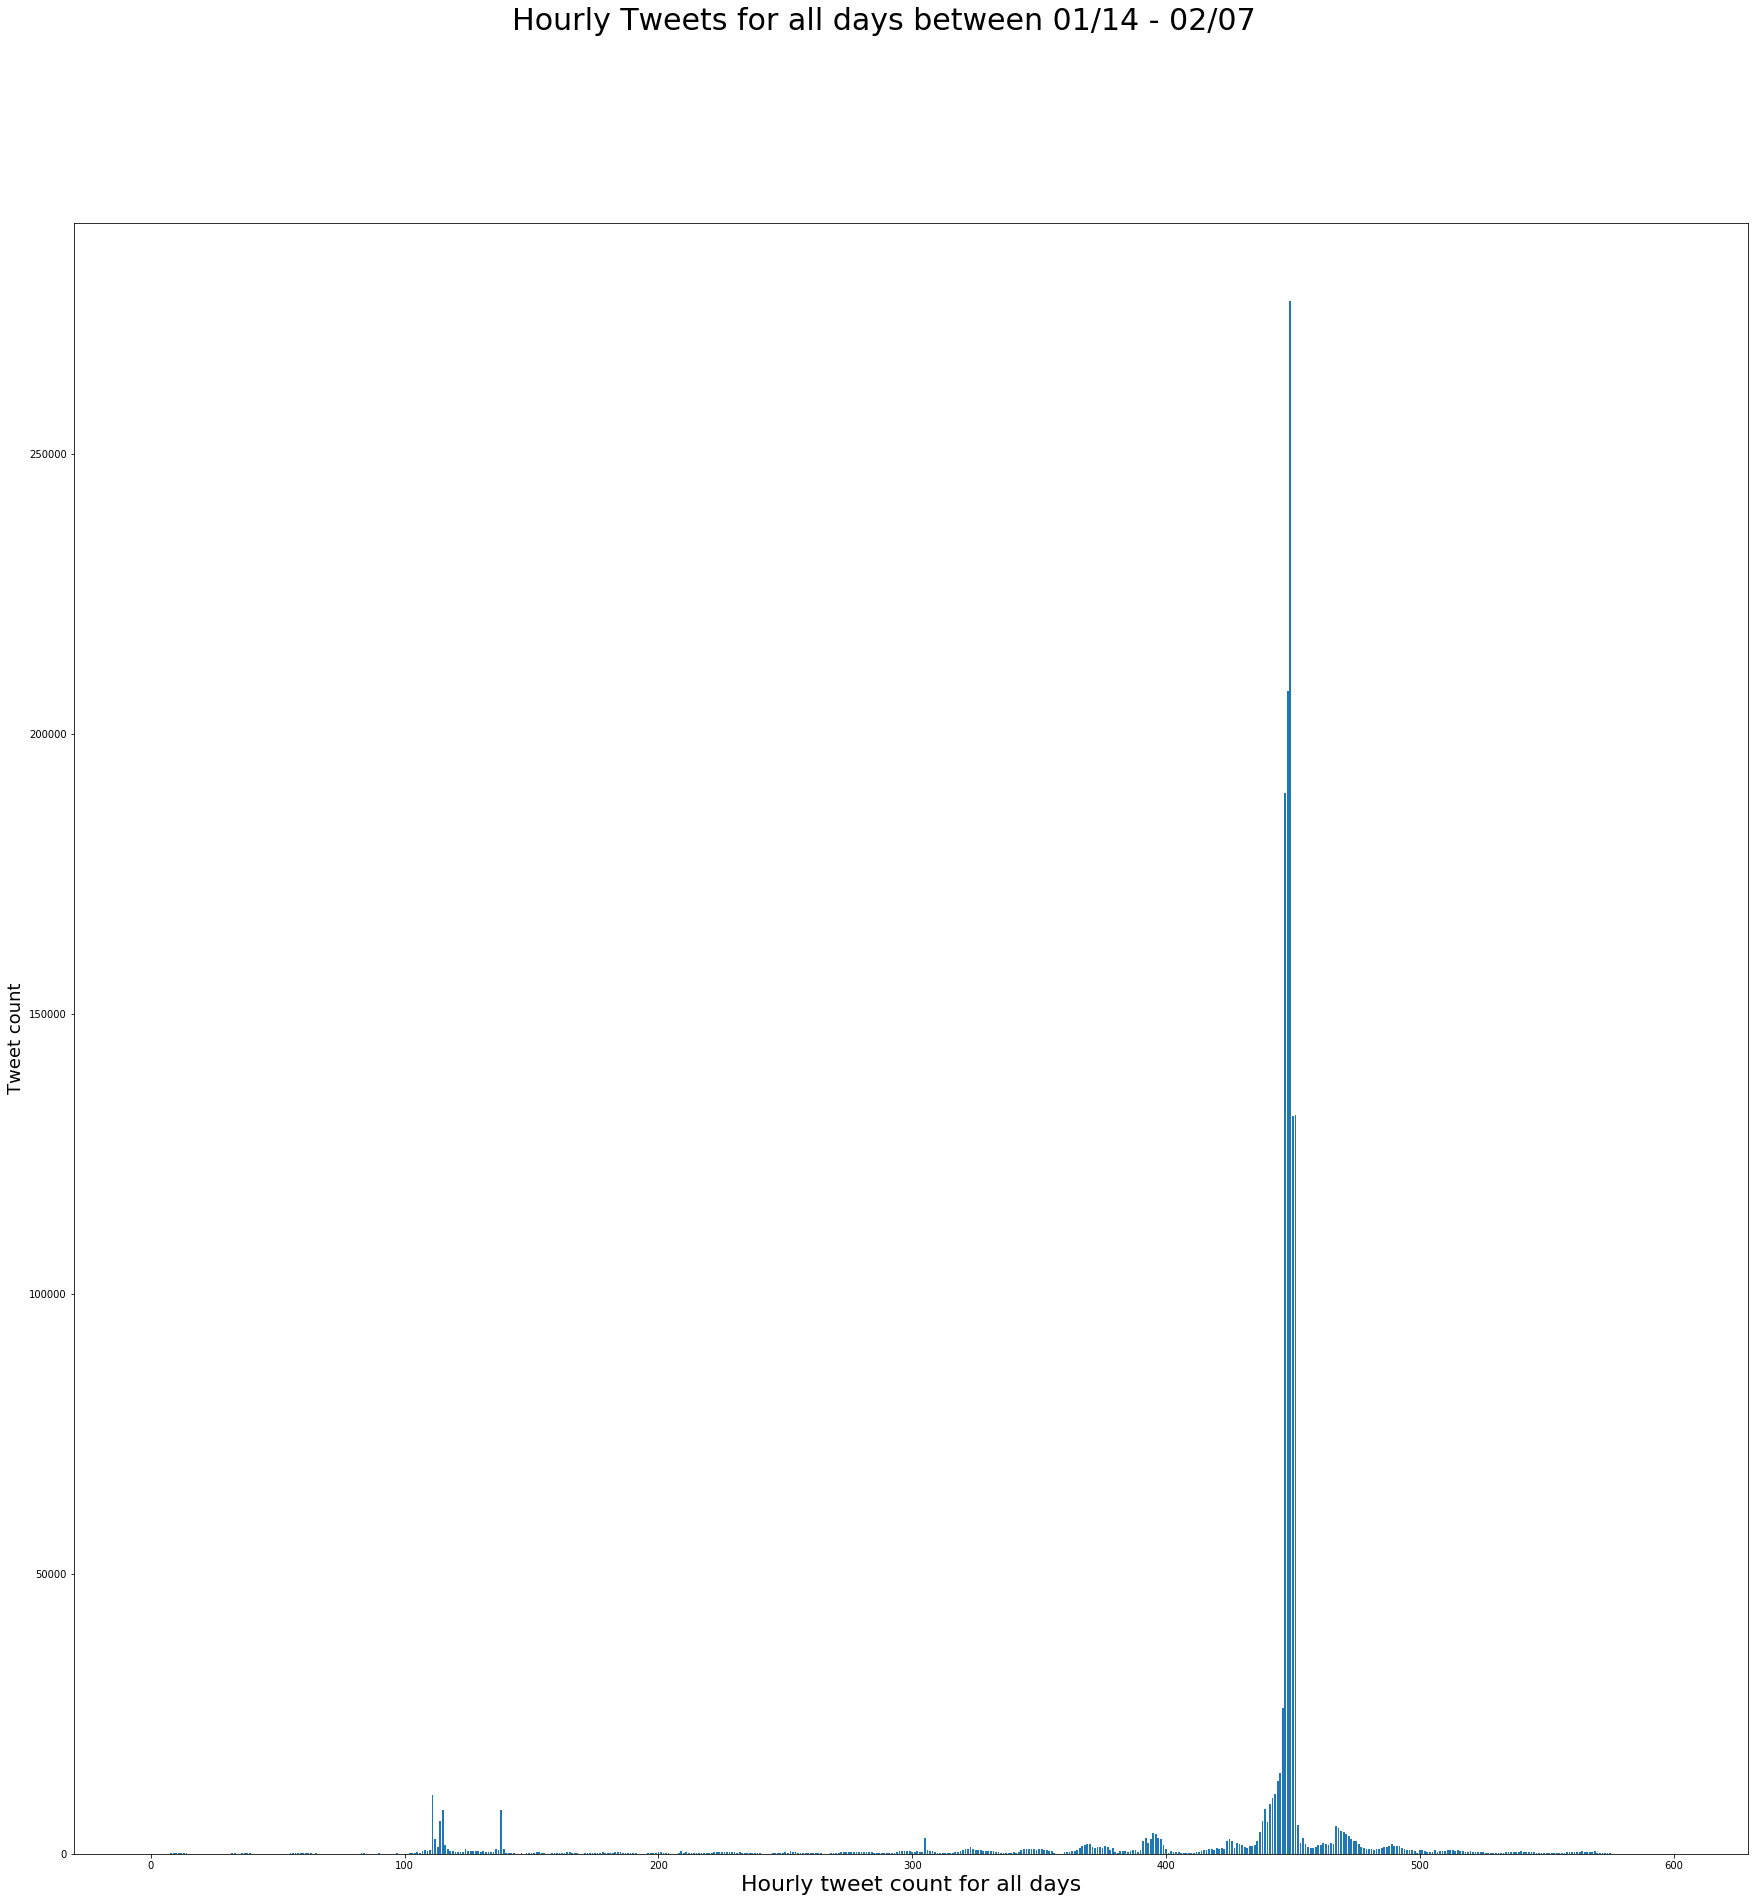

In [9]:
plotHourlyTweets(getHourlyTweets(tweetTimes['tweets_#superbowl.txt']))

## Q1.1 Plotting the number of tweets per hour across all days of data with the #nfl

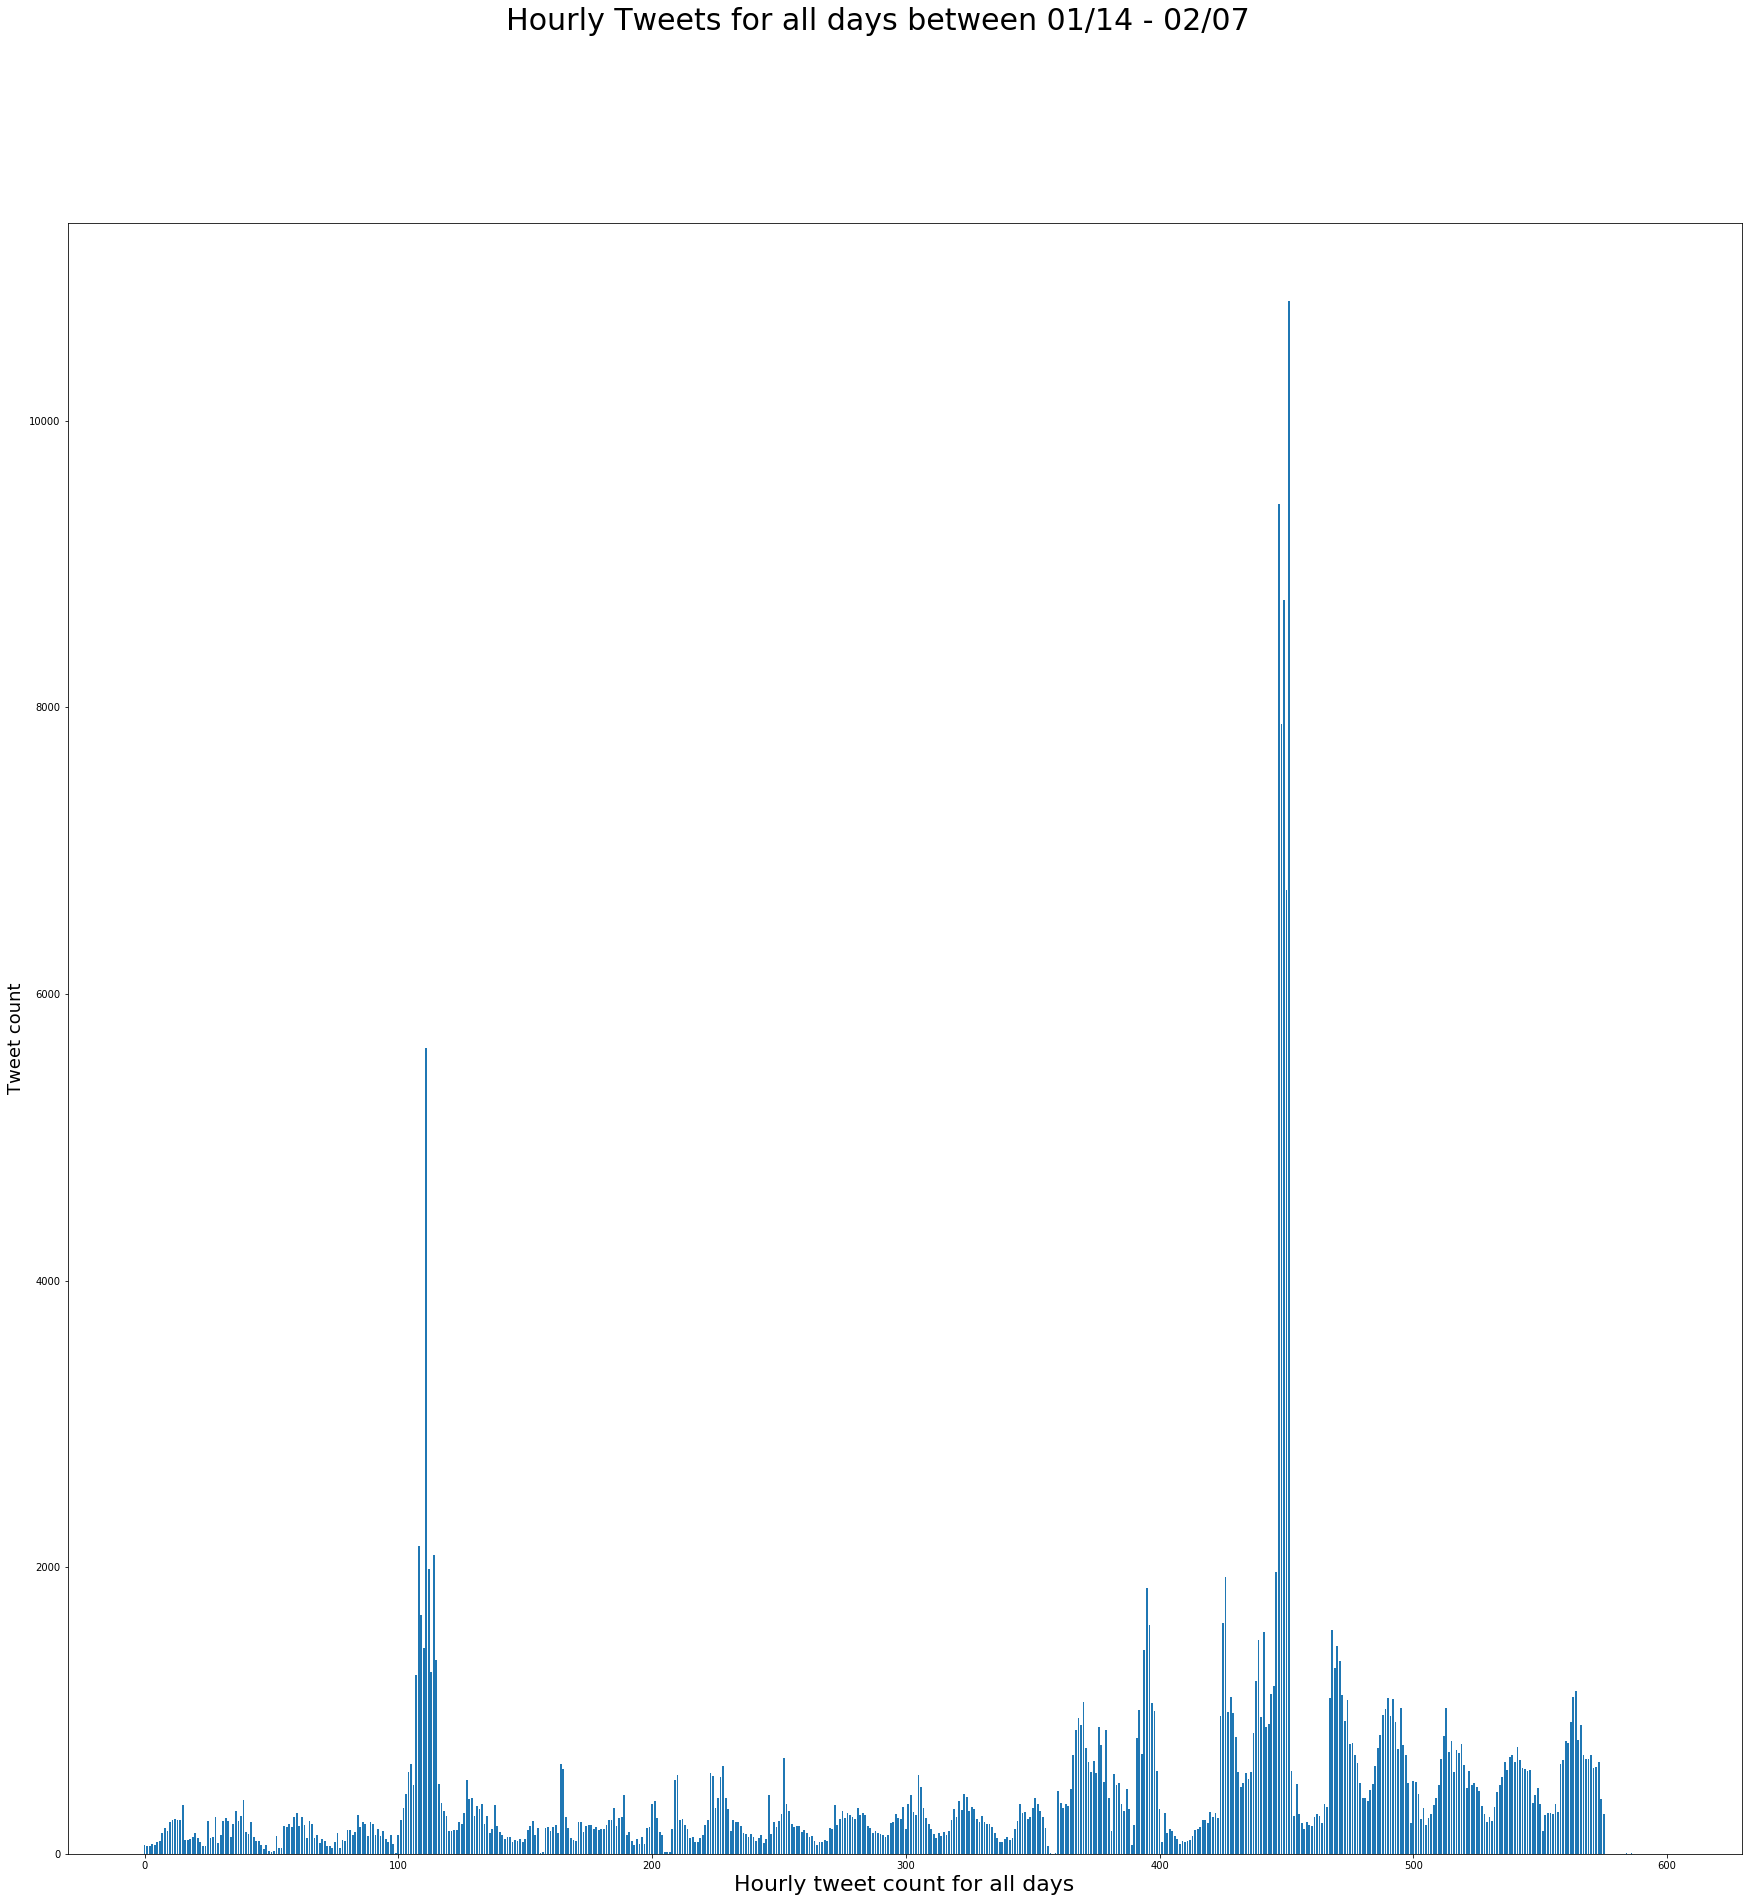

In [10]:
plotHourlyTweets(getHourlyTweets(tweetTimes['tweets_#nfl.txt']))

## Q1.2

In [11]:
load_data = True

if not load_data:
    
    tar = tarfile.open("data/tweet_data.tar.gz", "r:gz")
    
    featureData = {}

    pst_tz = pytz.timezone('US/Pacific')
    
    for member in tar.getmembers():
        f = tar.extractfile(member)
        featureValues = []
        for line in f.readlines():
            entry = json.loads(line)
            #Follower Data
            authorFollowers = entry['author']['followers']
            #Tweet time Data
            citation = entry['citation_date']
            tweetTime = datetime.datetime.fromtimestamp(citation, pst_tz)
            #Retweet Data
            retweetCount = entry['metrics']['citations']['total']
            
            featureValues.append([authorFollowers , tweetTime, retweetCount])
        
        featureData[member.name] = featureValues
        
        f.close()
    
    tar.close()
    
    with open('data/train/part1/part_1_2_data.pkl' , 'wb') as file:
        pickle.dump(featureData , file)
    
else:
    with open('data/train/part1/part_1_2_data.pkl' , 'rb') as file:
        featureData = pickle.load(file)
    

FileNotFoundError: [Errno 2] No such file or directory: 'data/train/part1/part_1_2_data.pkl'

In [12]:
def getHourlyFeatures(featureData):
    hourlyFeatures = {}
    
    for i in range(14,32):
        for j in range(0,24):
            hourlyFeatures[str(i) + ' '+ str(j)] = {'tweetCount' : 0, 'retweetCount' : 0, 'followerCount' : 0,
                                                    'maxFollowers' : 0, 'timeOfDay' : j}
    
    for i in range(1,8):
        for j in range(0,24):
            hourlyFeatures[str(i) + ' '+ str(j)] = {'tweetCount' : 0, 'retweetCount' : 0, 'followerCount' : 0,
                                                    'maxFollowers' : 0, 'timeOfDay' : j}
    
    for feature in featureData:
        day = feature[1].day
        hour = feature[1].hour
        followers = feature[0]
        retweets = feature[2]
        
        tweetCount = hourlyFeatures[str(day) + ' ' + str(hour)]['tweetCount']
        retweetCount = hourlyFeatures[str(day) + ' ' + str(hour)]['retweetCount']
        followerCount = hourlyFeatures[str(day) + ' ' + str(hour)]['followerCount']
        currentMax = hourlyFeatures[str(day) + ' ' + str(hour)]['maxFollowers']
        
        hourlyFeatures[str(day) + ' ' + str(hour)]['tweetCount'] = tweetCount + 1
        hourlyFeatures[str(day) + ' ' + str(hour)]['retweetCount'] = retweetCount + retweets
        hourlyFeatures[str(day) + ' ' + str(hour)]['followerCount'] = followerCount + followers
        hourlyFeatures[str(day) + ' ' + str(hour)]['maxFollowers'] = max(currentMax , followers)
        
    return hourlyFeatures

In [13]:
def generateFeatureVectors(hourlyFeatures):
    X = []
    y = []
    for i in range(15,32):
        for j in range(0,24):
            #For the first hour of the day we take the last hour of the previous day
            if j == 0:
                jj = 23
                ii = i -1
            else:
                jj = j - 1
                ii = i
                
            y.append([hourlyFeatures[str(i) + ' '+ str(j)]['tweetCount']])
            
            X.append([hourlyFeatures[str(ii) + ' '+ str(jj)]['tweetCount'],
                      hourlyFeatures[str(ii) + ' '+ str(jj)]['retweetCount'],
                      hourlyFeatures[str(ii) + ' '+ str(jj)]['followerCount'],
                      hourlyFeatures[str(ii) + ' '+ str(jj)]['maxFollowers'],
                      hourlyFeatures[str(ii) + ' '+ str(jj)]['timeOfDay']])
            
    for i in range(1,8):
        for j in range(0,24):
            #For the first hour of the day we take the last hour of the previous day
            if j == 0:
                jj = 23
                ii = i - 1
                if ii == 0:
                    ii = 31
            else:
                jj = j - 1
                ii = i
                
            y.append([hourlyFeatures[str(i) + ' '+ str(j)]['tweetCount']])
            
            X.append([hourlyFeatures[str(ii) + ' '+ str(jj)]['tweetCount'],
                      hourlyFeatures[str(ii) + ' '+ str(jj)]['retweetCount'],
                      hourlyFeatures[str(ii) + ' '+ str(jj)]['followerCount'],
                      hourlyFeatures[str(ii) + ' '+ str(jj)]['maxFollowers'],
                      hourlyFeatures[str(ii) + ' '+ str(jj)]['timeOfDay']])
            
    #for the first day we dont want hour 1 prediction
    for j in range(1,24):

        i = 14
        ii = 14
        jj = j - 1
                
        y.append([hourlyFeatures[str(i) + ' '+ str(j)]['tweetCount']])
            
        X.append([hourlyFeatures[str(ii) + ' '+ str(jj)]['tweetCount'],
                  hourlyFeatures[str(ii) + ' '+ str(jj)]['retweetCount'],
                  hourlyFeatures[str(ii) + ' '+ str(jj)]['followerCount'],
                  hourlyFeatures[str(ii) + ' '+ str(jj)]['maxFollowers'],
                  hourlyFeatures[str(ii) + ' '+ str(jj)]['timeOfDay']])
            
        
    return [np.array(X), np.array(y)]
    


## 1.2 Regression Results

In [14]:
for key in featureData.keys():
    [X, y] = generateFeatureVectors(getHourlyFeatures(featureData[key]))
    X = preprocessing.scale(X)
    X = sm.add_constant(X, prepend=False)
    mod = sm.OLS(y, X)
    res = mod.fit()
    y_d = res.predict()
    y_res = np.sum(np.square(y - y_d)) / len(y)
    rmse = np.sqrt(y_res)
    print('\n The regression results for the tweets with the hashtag %s are '% key[7:-4])
    print(res.summary())
    print('\n RMSE : %f' % rmse)

NameError: name 'featureData' is not defined

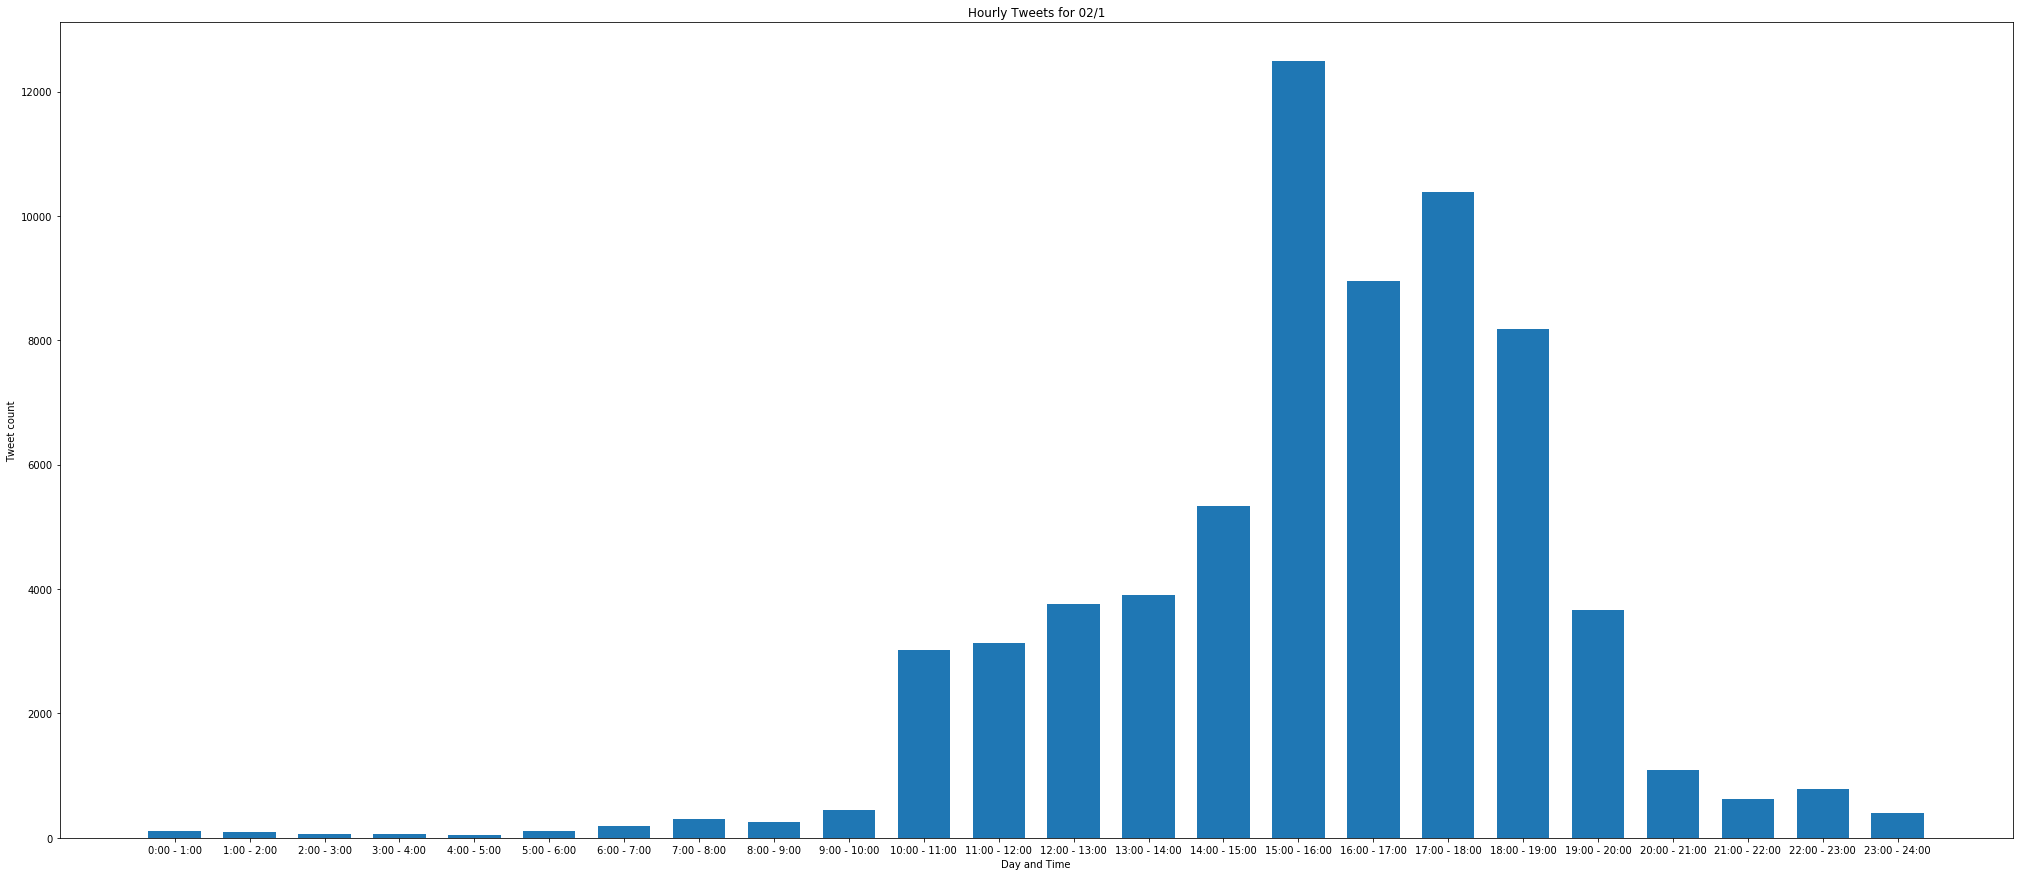

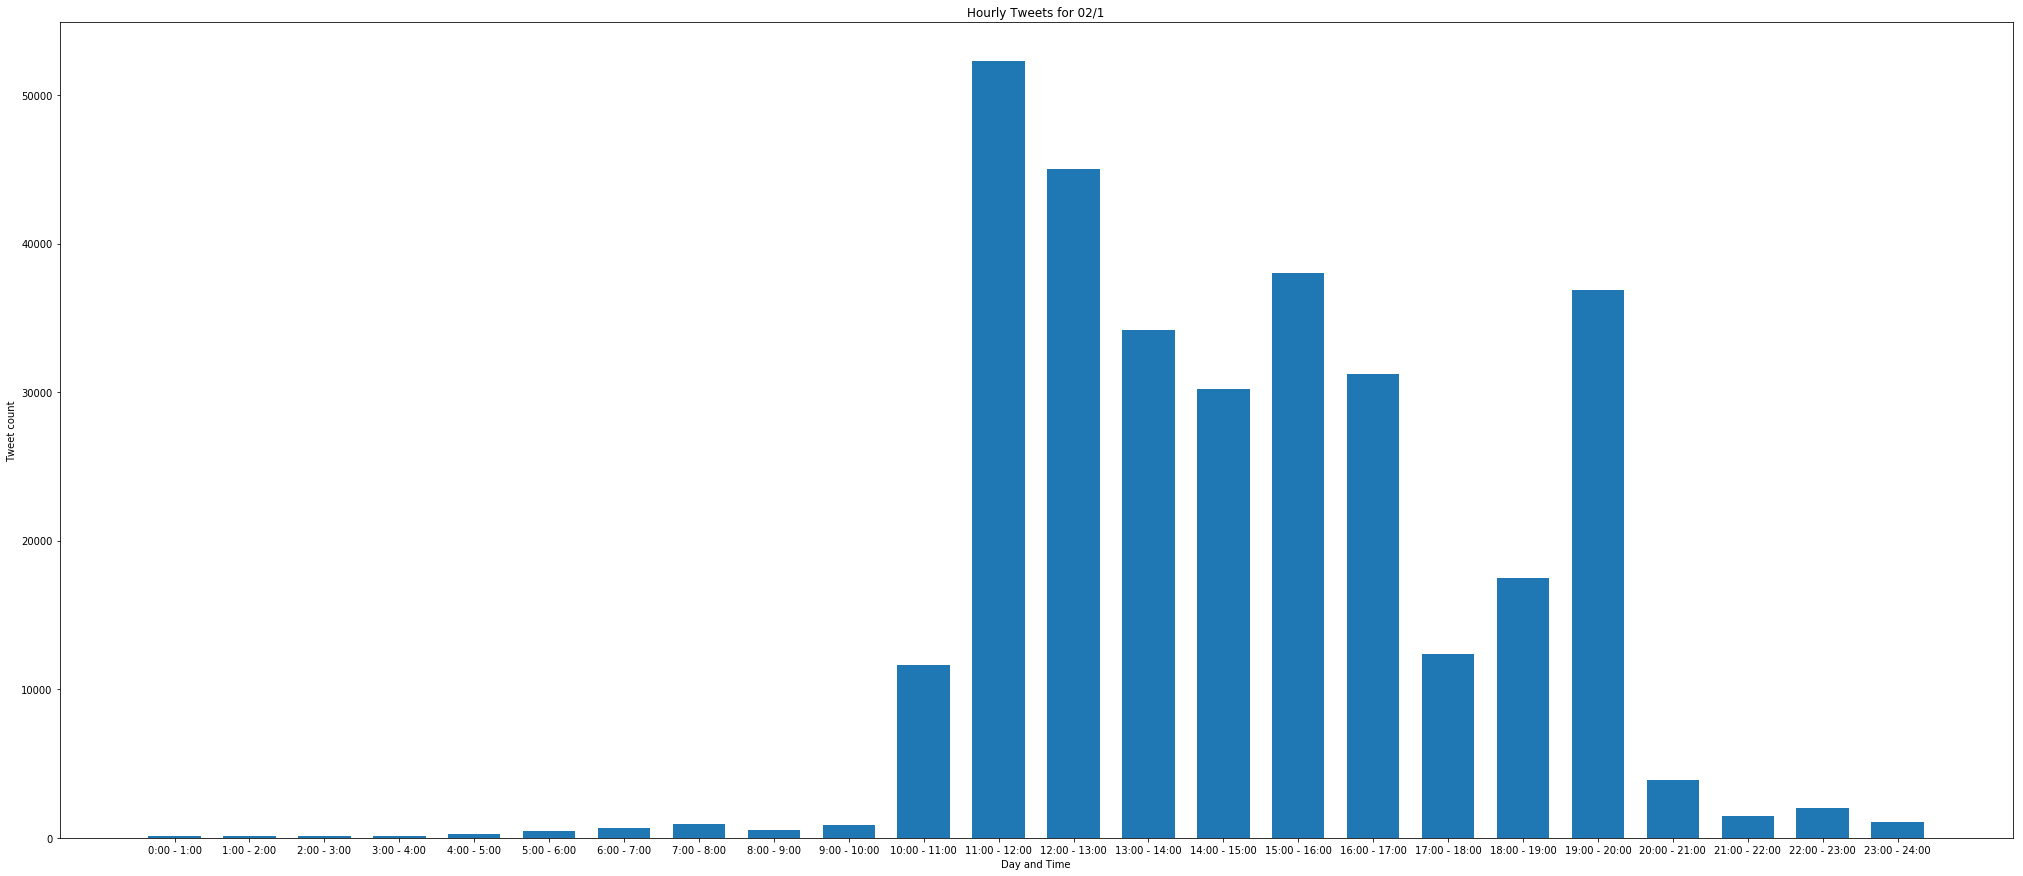

In [15]:
with open('data/train/part1/part_1_1_data.pkl' , 'rb') as file:
        [avgFollowers, tweetTimes, avgRetweets] = pickle.load(file)
tweetTimes = getHourlyTweets(tweetTimes['tweets_#gohawks.txt'])
x = []
y = []
for i in range(1,2):
    for j in range(0,24):
        key = str(i)+ ' '+ str(j)
        x.append(str(j) + ':00 - ' + str(j+1)+ ':00')
        y.append(tweetTimes[key])
    xx = np.arange(0,24)
    plt.figure(figsize=(35,15))
    binwidth = 0.7
    plt.bar(xx , y, width = binwidth)
    plt.xticks(xx, x)
    plt.xlabel('Day and Time')
    plt.ylabel('Tweet count')
    plt.title('Hourly Tweets for %s' % ('02/' + str(i)))
    plt.show()
    
with open('data/train/part1/part_1_1_data.pkl' , 'rb') as file:
        [avgFollowers, tweetTimes, avgRetweets] = pickle.load(file)
tweetTimes = getHourlyTweets(tweetTimes['tweets_#patriots.txt'])
x = []
y = []
for i in range(1,2):
    for j in range(0,24):
        key = str(i)+ ' '+ str(j)
        x.append(str(j) + ':00 - ' + str(j+1)+ ':00')
        y.append(tweetTimes[key])
    xx = np.arange(0,24)
    plt.figure(figsize=(35,15))
    binwidth = 0.7
    plt.bar(xx , y, width = binwidth)
    plt.xticks(xx, x)
    plt.xlabel('Day and Time')
    plt.ylabel('Tweet count')
    plt.title('Hourly Tweets for %s' % ('02/' + str(i)))
    plt.show()
